In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

data = pl.read_parquet("../data/raw/topstocks_train.parquet")
supp = pl.read_parquet("../data/raw/topstocks_supplementary.parquet")
supp_comp = supp.filter(pl.col("ticker") == "COMP")

data = data.join(supp.filter(pl.col("ticker") == "DJIA").drop("ticker"), on="date", how="left", suffix="_DJIA")
data = data.join(supp.filter(pl.col("ticker") == "COMP").drop("ticker"), on="date", how="left", suffix="_COMP")

month = data["date"].str.extract(r"(.*)/.*/.*").str.to_integer()
day = data["date"].str.extract(r".*/(.*)/.*").str.to_integer()
year = data["date"].str.extract(r".*/.*/(.*)").str.to_integer()
data = data.with_columns(pl.date(year, month, day).alias("date"))

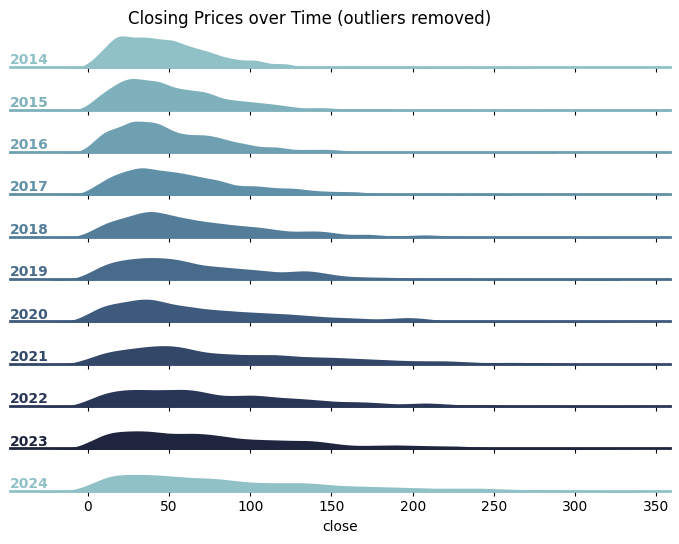

In [2]:
def ridgeline_plot(df, col, row): # mostly copied from example at https://seaborn.pydata.org/examples/kde_ridgeplot
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    grid = sns.FacetGrid(df, row=row, hue=row, aspect=15, height=.5, palette=pal)
    grid.map(sns.kdeplot, col, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    grid.map(sns.kdeplot, col, clip_on=False, color="w", lw=2, bw_adjust=.5)
    grid.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)
    grid.map(label, col)

    grid.figure.subplots_adjust(hspace=.25)
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.despine(bottom=True, left=True)
    return grid

avg_prices = data.with_columns(pl.col("date").dt.year().alias("year")).group_by(("ticker", "year")).agg(pl.col("close").mean())
avg_prices = avg_prices.filter(pl.col("close") < pl.col("close").mean() + (pl.col("close").std()))
plot = ridgeline_plot(avg_prices, "close", "year")
plot.figure.suptitle("Closing Prices over Time (outliers removed)");

Text(0.5, 1.0, 'Unnormalized Correlation Matrix')

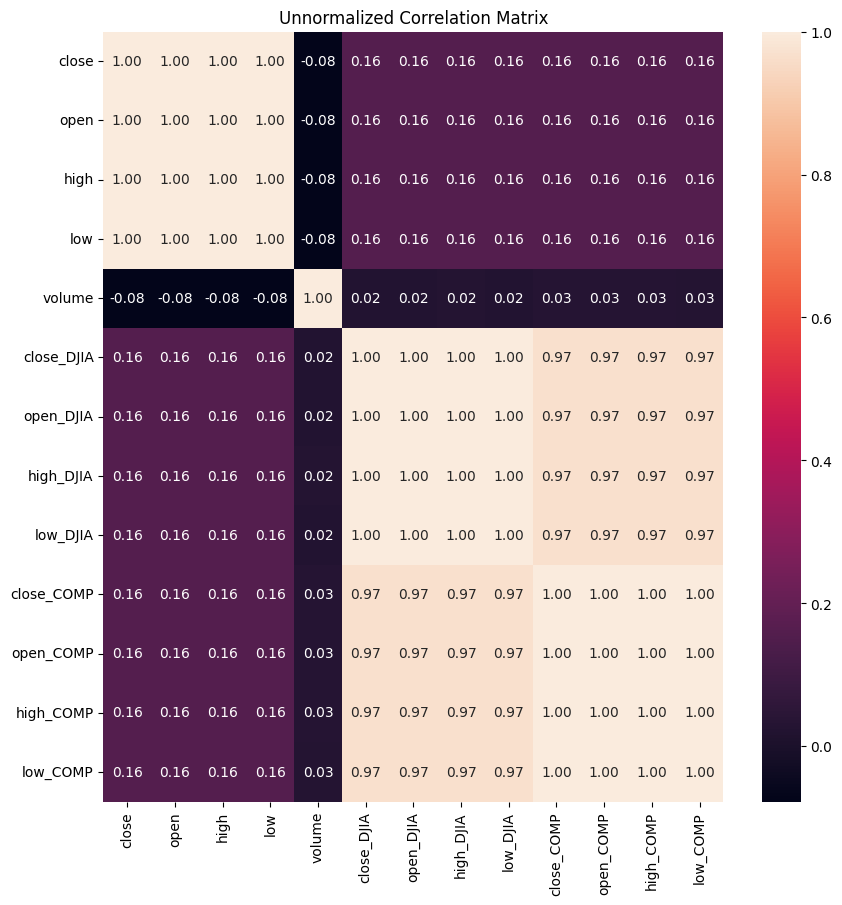

In [3]:
corr1 = data.select(pl.col(pl.NUMERIC_DTYPES)).corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
corr_map1 = sns.heatmap(corr1, annot=True, fmt=".2f", xticklabels=corr1.columns, yticklabels=corr1.columns, ax=ax)
corr_map1.set_title("Unnormalized Correlation Matrix")


Text(0.5, 1.0, 'Normalized Correlation Matrix')

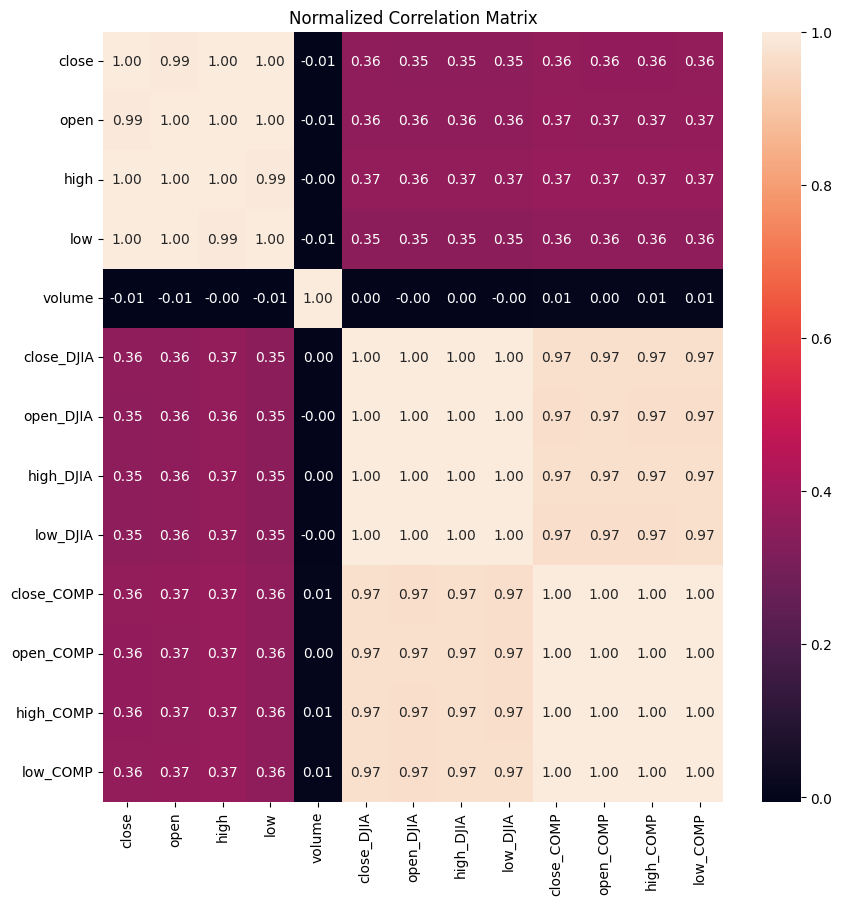

In [4]:
data_norm = data.sort("date").group_by("ticker").agg(pl.col("date"), (pl.col(pl.NUMERIC_DTYPES) / pl.col(pl.NUMERIC_DTYPES).first()) - 1)
data_norm = data_norm.explode(columns=data_norm.columns[1:])
corr2 = data_norm.select(pl.col(pl.NUMERIC_DTYPES)).corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
corr_map2 = sns.heatmap(corr2, annot=True, fmt=".2f", xticklabels=corr2.columns, yticklabels=corr2.columns, ax=ax)
corr_map2.set_title("Normalized Correlation Matrix")

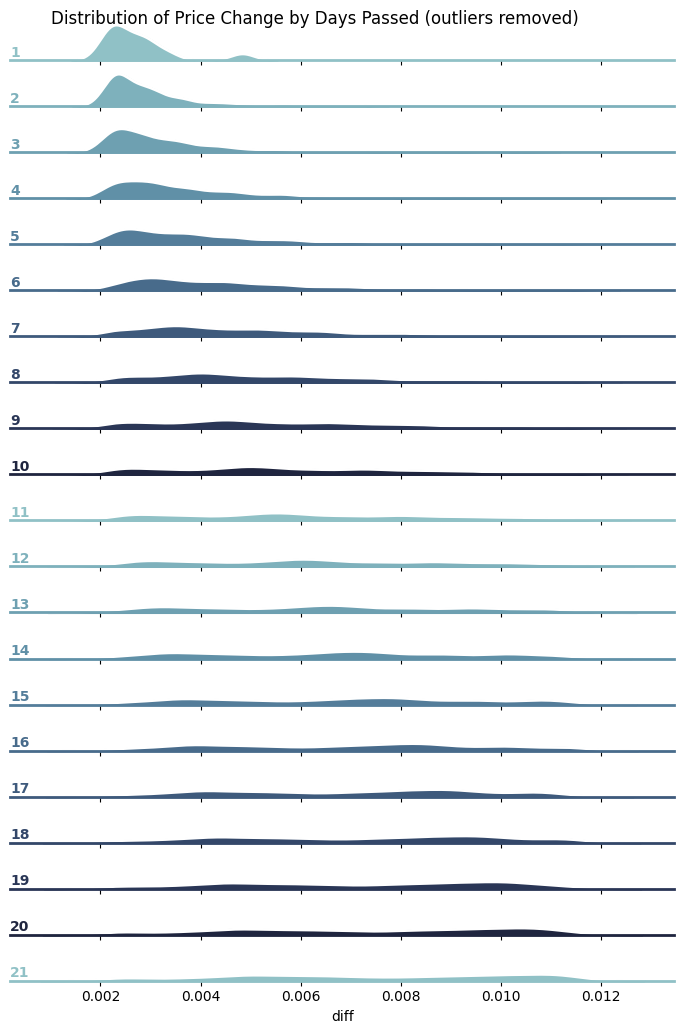

In [5]:
closes = data.sort("date").group_by("ticker").agg(pl.col("close"))
l = pl.col("close").list
diff_dist = pl.concat([closes.select(pl.col("ticker"), 
                                     l.tail(l.len()-i).alias("a"), 
                                     l.head(l.len()-i).alias("b"))
                             .explode(columns=("a", "b"))
                             .select(pl.col("ticker"),
                                     ((pl.col("a") / pl.col("b")) - 1).alias("diff"))
                             .group_by("ticker")
                             .agg(pl.col("diff").mean(), pl.lit(i).alias("ndays"))
                        for i in range(1, 22)])
diff_dist = diff_dist.filter((pl.col("diff") - pl.col("diff").mean()).abs() < 0.5*pl.col("diff").std())
plot = ridgeline_plot(diff_dist, "diff", "ndays")
plot.figure.suptitle("Distribution of Price Change by Days Passed (outliers removed)");